<a href="https://colab.research.google.com/github/TyBuie/DatasetCustomerSupportTweets/blob/main/Sentiment_Analysis_using_VaderBuie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install vaderSentiment

     |████████████████████████████████| 133kB 6.4MB/s 


In [ ]:
import pandas as pd
import numpy as np
import time
import re
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud

from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
from gensim.models.phrases import Phrases, Phraser


In [ ]:
import os

In [ ]:
file_input = 'processed_without_stopwords_1000000_inbound_outbound_not_lemmatized.pkl' 
from google.colab import drive 
drive.mount('/content/drive') 
file_path = '/content/drive/My Drive/' 
os.chdir( file_path ) 
os.getcwd()


Mounted at /content/drive


'/content/drive/My Drive'

In [ ]:
! pip install wordcloud

### Variables and Data Structures

In [ ]:
vs = SentimentIntensityAnalyzer()
nlp = en_core_web_sm.load()

### These are some noise data,identified in our corpus, going to eliminate these as stopwords .. will retain these for product/service insights

stop = {'customer','order','phone','hello','hi','fargo','help','xbox','time','driver','lyft','uber','amazon','prime',
        'si ample','direct message','credit card','amp','li amit','good'}

In [ ]:
### Patterns & Handy Functions

vowels = re.compile('[aeiou]')
company = re.compile('[0-9@]')

### Text cleaning,removal of aa,bb,oo kind of words

def remove_two_three_words(text):
    text = [word for word in text.split() if (len(word)!=2 | len(word)!=3) & (vowels.search(word)!=None)  & (len(vowels.findall(word)) != len(word))] #creates boolean, if 2/3 word not present = True
    text = list(set(text))
    if len(text)>1:
        return text
    else:
        return None

### Labelling the tweets as Positive,Negative & Neutral

def analyse_tweet(text):
    sentiment = vs.polarity_scores(text)
    if sentiment['compound'] >= 0.05:
        return 'positive'
    elif sentiment['compound'] <= - 0.05 :
        return 'negative'
    else:
        return 'neutral'
    
### Lable company names from the author_id

def retain_org_names(text):
    if text!='XXXXX':
        text = text.split('@')[1]
        if text.isdigit() == False:
            return text.lower()
        else:
            return None


### Utility methods

def join_text(text):
    return ' '.join(text)
        
def __remove_stopwords(text,stopwords):
        tokens = re.split('\W+',text)
        text = [word for word in tokens if word not in stopwords and word]
        return ' '.join(text)

def strip(text):
    if text== 'xxxxx':
        return None
    elif len(text.strip())==0:
        return None
    else:
        return text 
    
def return_tweet_id(tweet):
    tweet = tweet.split(",")
    count = len(tweet)
    return count

def eliminate_pattern(text,pt):
    text = pt.sub('',text)
    return text.lower()

In [ ]:
print('best pickle so far, without stopwords but not lemmatized',datetime.now())  
df_input = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/processed_without_stopwords_1000000_inbound_outbound_not_lemmatized.pkl')

best pickle so far, without stopwords but not lemmatized 2021-06-28 17:26:20.027992


In [ ]:
print(df_input.shape)
df_input.dropna(inplace=True)
print(df_input.shape)

(557391, 8)
(377479, 8)


In [ ]:
df_input.head()

,tweet_id,response_tweet_id,created_at,author_id,sent_to_user,cleaned_text,inbound,feature_text
0,1,2,Tue Oct 31 22:10:47 +0000 2017,sprintcare,@115712,i understand would like to assist you we would...,False,understand like assist need private secured li...
2,3,1,Tue Oct 31 22:08:27 +0000 2017,115712,@sprintcare,i have sent several private messages and no on...,True,sent private message responding usual
4,5,4,Tue Oct 31 21:49:35 +0000 2017,115712,@sprintcare,i did,True,
5,6,"5,7",Tue Oct 31 21:46:24 +0000 2017,sprintcare,@115712,can you please send us private message so that...,False,send private message gain detail account
6,8,"9,6,10",Tue Oct 31 21:45:10 +0000 2017,115712,@sprintcare,is the worst customer service,True,worst customer service


## Read data from the cleaned data pickled file from Data Processing Module

### Perform Vader Sentiment Analysis to label

In [ ]:
now = time.time()
df_input['sentiment'] = df_input.cleaned_text.apply(analyse_tweet)
print('minutes',(time.time() - now)/60)

minutes 0.7418621897697448


### Preparing text for WordCloud Visualization

In [ ]:
df_input.dropna(inplace=True)
df_input['feature_text_cleaned'] = df_input['feature_text'].apply(remove_two_three_words)
df_input.dropna(inplace=True)
df_input['feature_text_cleaned'] = df_input['feature_text_cleaned'].apply(join_text) 
df_input.dropna(inplace=True)

In [ ]:
df_input.inbound.value_counts()

True     218483
False     97694
Name: inbound, dtype: int64

### Visualizing only incoming tweets and drawing insights from them

In [ ]:
df = df_input[df_input['inbound'] == True]

In [ ]:
df['features_nostop'] = df['feature_text_cleaned'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_input.to_csv(r' Name.csv', index = False)


### We are going to convert the texts to n-grams or sequential phrases like (I like reading) so that the context of the tweet labelled as negative or positive can be visualized. We will use the Gensim Phraser library

In [ ]:
now = time.time()

sent_overall = [row for row in df.features_nostop]
phrases_overall = Phrases(sent_overall, min_count=3, progress_per=50000)
bigram_overall = Phraser(phrases_overall)
sentences_overall = bigram_overall[sent_overall]

sent_positive = [row for row in df[df['sentiment']=='positive'].features_nostop]
phrases_positive = Phrases(sent_positive, min_count=3, progress_per=50000)
bigram_positive = Phraser(phrases_positive)
sentences_positive = bigram_positive[sent_positive]

sent_negative = [row for row in df[df['sentiment']=='negative'].features_nostop]
phrases_negative = Phrases(sent_negative, min_count=3, progress_per=50000)
bigram_negative = Phraser(phrases_negative)
sentences_negative = bigram_negative[sent_negative]

sent_neutral = [row for row in df[df['sentiment']=='neutral'].features_nostop]
phrases_neutral = Phrases(sent_neutral, min_count=3, progress_per=50000)
bigram_neutral = Phraser(phrases_neutral)
sentences_neutral = bigram_neutral[sent_neutral]

print('minutes',(time.time() - now)/60)

minutes 0.3223693331082662


In [ ]:
!pip install wordcloud
from wordcloud import WordCloud

In [ ]:
now = time.time()

comments_overall = ' '.join(sent_overall)
comments_positive = ' '.join(sent_positive)
comments_negative = ' '.join(sent_negative)
comments_neutral = ' '.join(sent_neutral)
w = 800
h =800
m = 6
wordcloud_positive = WordCloud(width = w, height = h,
                background_color ='white',stopwords = stop,
                min_font_size = m).generate(comments_positive)
wordcloud_negative = WordCloud(width = w, height = h,stopwords = stop,
                background_color ='white',
                min_font_size = m).generate(comments_negative)
wordcloud_neutral = WordCloud(width = w, height = h,
                background_color ='white',stopwords = stop,
                min_font_size = m).generate(comments_neutral)
wordcloud_overall = WordCloud(width = w, height = h,
                background_color ='white',stopwords = stop,
                min_font_size = m).generate(comments_overall)

print('minutes',(time.time() - now)/60)

minutes 0.32843945026397703


In [ ]:
now = time.time()

comments_overall = ' '.join(sent_overall)
comments_positive = ' '.join(sent_positive)
comments_negative = ' '.join(sent_negative)
comments_neutral = ' '.join(sent_neutral)
w = 800
h =800
m = 6
wordcloud_positive = WordCloud(width = w, height = h,
                background_color ='white',stopwords = stop,
                min_font_size = m ).generate(comments_positive)
wordcloud_negative = WordCloud(width = w, height = h,stopwords = stop,
                background_color ='white',
                min_font_size = m).generate(comments_negative)
wordcloud_neutral = WordCloud(width = w, height = h,
                background_color ='white',stopwords = stop,
                min_font_size = m).generate(comments_neutral)
wordcloud_overall = WordCloud(width = w, height = h,
                background_color ='white',stopwords = stop,
                min_font_size = m).generate(comments_overall)

print('minutes',(time.time() - now)/60)

minutes 0.3329988519350688


### Plotting the Overall Wordcloud

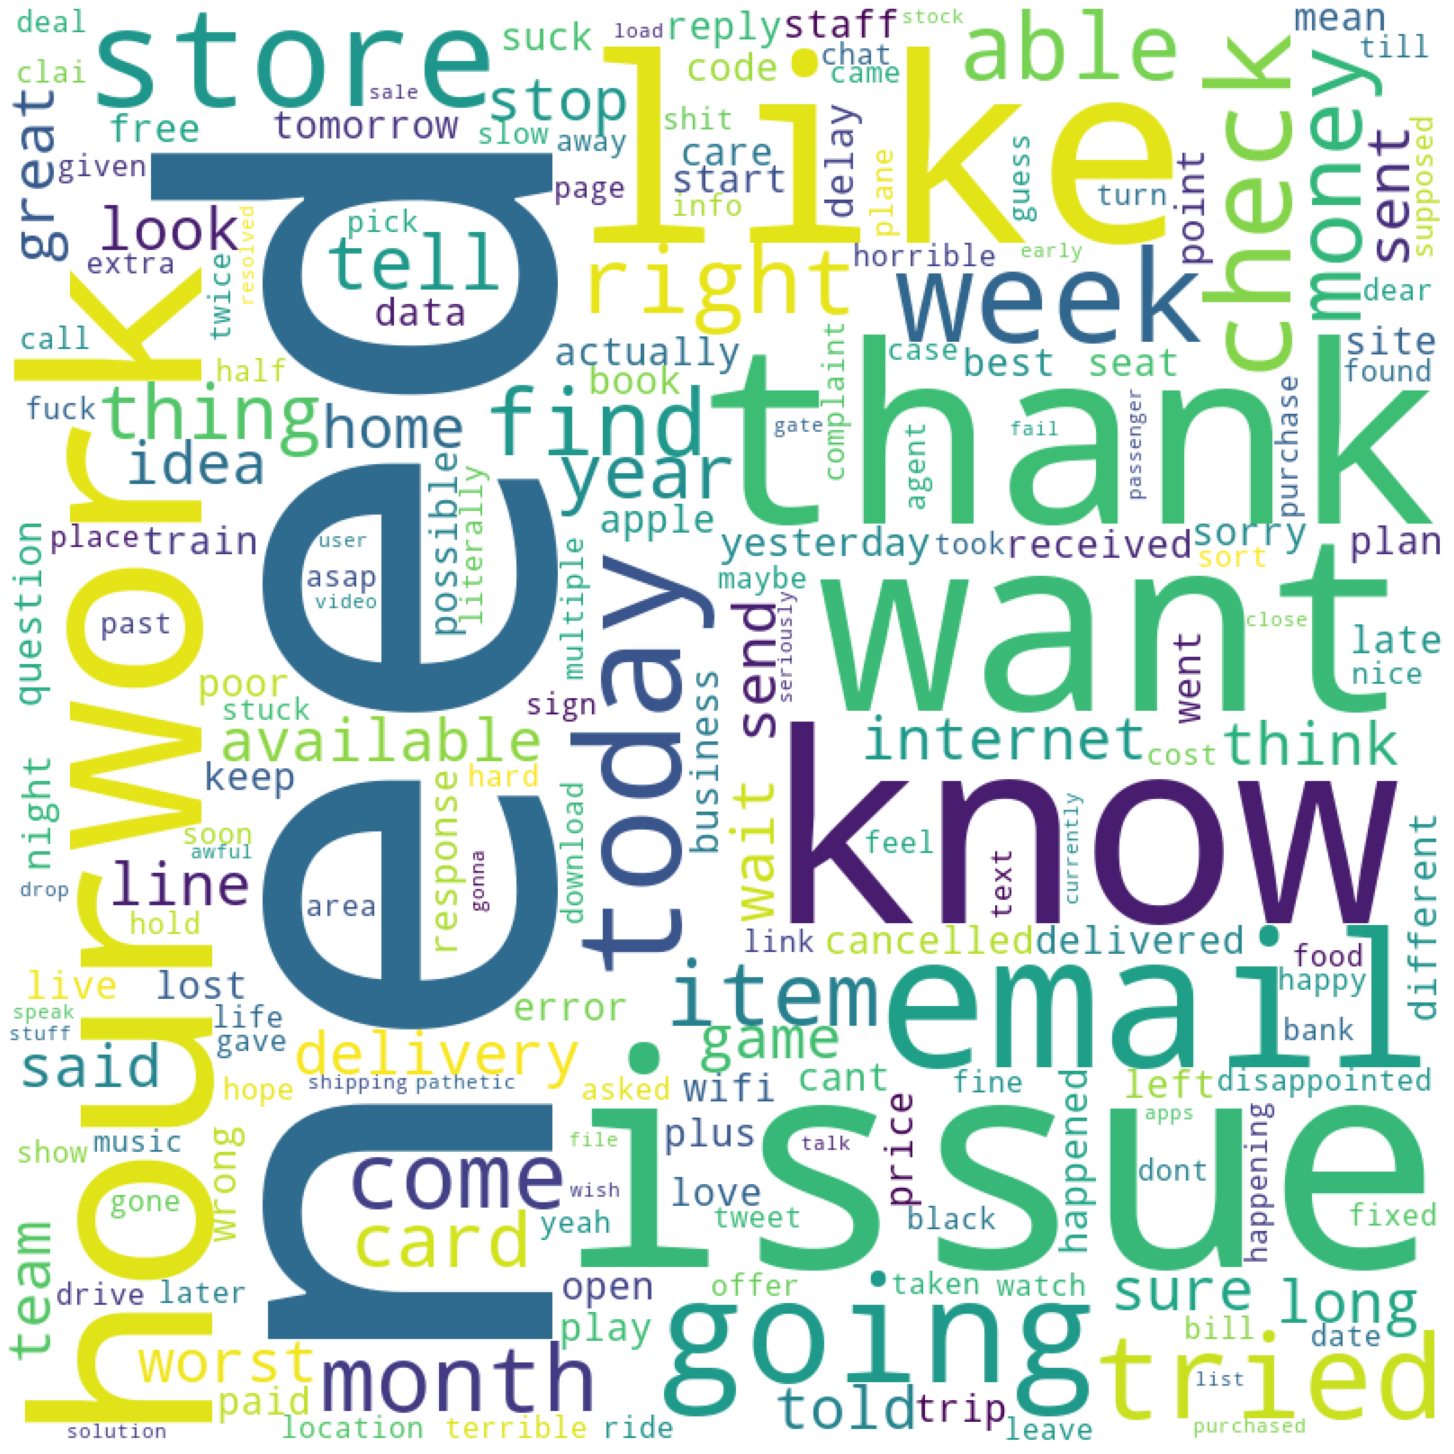

minutes 0.01791680653889974


In [ ]:
now = time.time()
plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud_overall)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()
print('minutes',(time.time() - now)/60)

### Plotting the Positive Wordcloud,the cloud has a lot many positive phrases that shows the labelling is somewhat accurate with the data that we have used

In [ ]:
now = time.time()
plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud_positive)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()
print('minutes',(time.time() - now)/60)

### Plotting the Negative Wordcloud,this cloud has a lot many negative phrases that shows the labelling is somewhat accurate with the data that we have used

In [ ]:
now = time.time()
plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud_negative)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()
print('minutes',(time.time() - now)/60)

### Plotting the Neutral Wordcloud

In [ ]:
now = time.time()
plt.figure(figsize = (20, 20), facecolor = None)
plt.imshow(wordcloud_neutral)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()
print('minutes',(time.time() - now)/60)

### Save the WordCloud to File

In [ ]:
# wordcloud_positive.to_file('wordcloud_positive.png')
# wordcloud_negative.to_file('wordcloud_negative.png')
# wordcloud_neutral.to_file('wordcloud_neutral.png')
# wordcloud_neutral.to_file('wordcloud_overall.png')

## Analysis of Inbound Tweets - Company & Industry wise

In [ ]:
print(df.columns)
print(df.inbound.value_counts())

Index(['tweet_id', 'response_tweet_id', 'created_at', 'author_id',
       'sent_to_user', 'cleaned_text', 'inbound', 'feature_text', 'sentiment',
       'feature_text_cleaned', 'features_nostop'],
      dtype='object')
True    218483
Name: inbound, dtype: int64


### We are going to create the company name using the author id

In [ ]:
df['company name'] = df['sent_to_user'].apply(retain_org_names)
df.dropna(inplace=True)
df_ = df.groupby('company name').filter(lambda x : len(x)>100)  ### Only going to use company name total counts > 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
industry = set(df_['company name'].unique())  ### We will map the company names to the industry they belong to based on common knowledge , example Airways,Bank etc,
### u can add more

In [ ]:
industry_dict = {'adobecare':'IT','airasiasupport':'AIRWAYS','airbnbhelp':'HOSPITALITY','airtelcare':'TELECOM','alaskaair':'AIRWAYS',
'aldiuk':'E-COMMERCE','amazonhelp':'E-COMMERCE','americanair':'AIRWAYS','applesupport':'ELECTRONICS','arbyscares':'RESTAURANT',
'argoshelpers':'E-COMMERCE','askamex':'BANK','askciti':'BANK','askebay':'E-COMMERCE','asklyft':'CAB','askpapajohns':'RESTAURANT',
'askpaypal':'PAYMENTS','askplaystation':'GAMING','askspectrum':'TELECOM','asktarget':'RETAILER','askvirginmoney':'PAYMENTS',
'askwellsfargo':'BANK','askwellsfargo':'BANK','asurioncares':'INSURANCE','att':'TELECOM','atviassist':'CONTENT-PROVIDER','azuresupport':'CLOUD-PROVIDER',
'bofahelp':'BANK','britishairways':'AIRWAYS','centurylinkhelp':'TELECOM','chasesupport':'BANK','chipotletweets':'RESTAURANT',
'comcastcares':'TELECOM','coxhelp':'TOURISM','dellcares':'IT','delta':'AIRWAYS','doordashhelp':'FOODDELIVERY','dropboxsupport':'IT',
 'dunkindonuts':'RESTAURANT','glocare':'TELECOM','godaddyhelp':'IT','googleplaymusic':'CONTENT-PROVIDER','greggsofficial':'RESTAURANT',
 'gwrhelp':'RAILWAYS','hpsupport':'IT','hulusupport':'CONTENT_PROVIDER','ideacares':'TELECOM','ihgservice':'TOURISM','jetblue':'AIRWAYS',
 'kfcukihelp':'RESTAURANT','kimpton':'HOSPITALITY','londonmidland':'BANK','marksandspencer':'RETAILER','mcdonalds':'RESTAURANT',
 'microsofthelps':'IT','morrisons':'E-COMMERCE','nationalrailenq':'RAILWAYS','nikesupport':'RETAILER','nortonsupport':'IT',
 'o2':'TELECOM','postmateshelp':'FOODDELIVERY','safaricomcare':'TELECOM','sainsburys':'RETAILER','scsupport':'BANK','sizehelpteam':'PERSONALGROOMING',
 'southwestair':'AIRWAYS','spotifycares':'CONTENT-PROVIDER','sprintcare':'TELECOM','swhelp':'RAILWAYS','tacobellteam':'RESTAURANT',
 'tesco':'RETAILER','tfl':'RAILWAYS','tmobilehelp':'TELECOM','twittersupport':'CONTENT_PROVIDER','ubersupport':'CAB',
 'upshelp':'LOGISTICS','uscellularcares':'TELECOM','verizonsupport':'TELECOM','virginamerica':'AIRWAYS','virginatlantic':'AIRWAYS',
 'virgintrains':'RAILWAYS','vmucare':'TELECOM','xboxsupport':'GAMING','yahoocare':'IT'}

In [ ]:
df['industry'] = df['company name']
df_['industry'].replace(industry_dict,inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


KeyError: ignored

#### 1. Tweet Count Analysis 

In [ ]:
df_.groupby('company name')['sentiment'].count().sort_values(ascending = False)

company name
amazonhelp         21008
applesupport        7757
ubersupport         6239
delta               5247
americanair         5212
                   ...  
twittersupport       122
dunkindonuts         119
doordashhelp         118
ihgservice           114
googleplaymusic      111
Name: sentiment, Length: 83, dtype: int64

In [ ]:
df_.groupby(['industry'])['sentiment'].count().plot(kind='bar',stacked=False,figsize=(15,8),title = 'Count Of Tweets - Industry',colormap='plasma')

KeyError: ignored

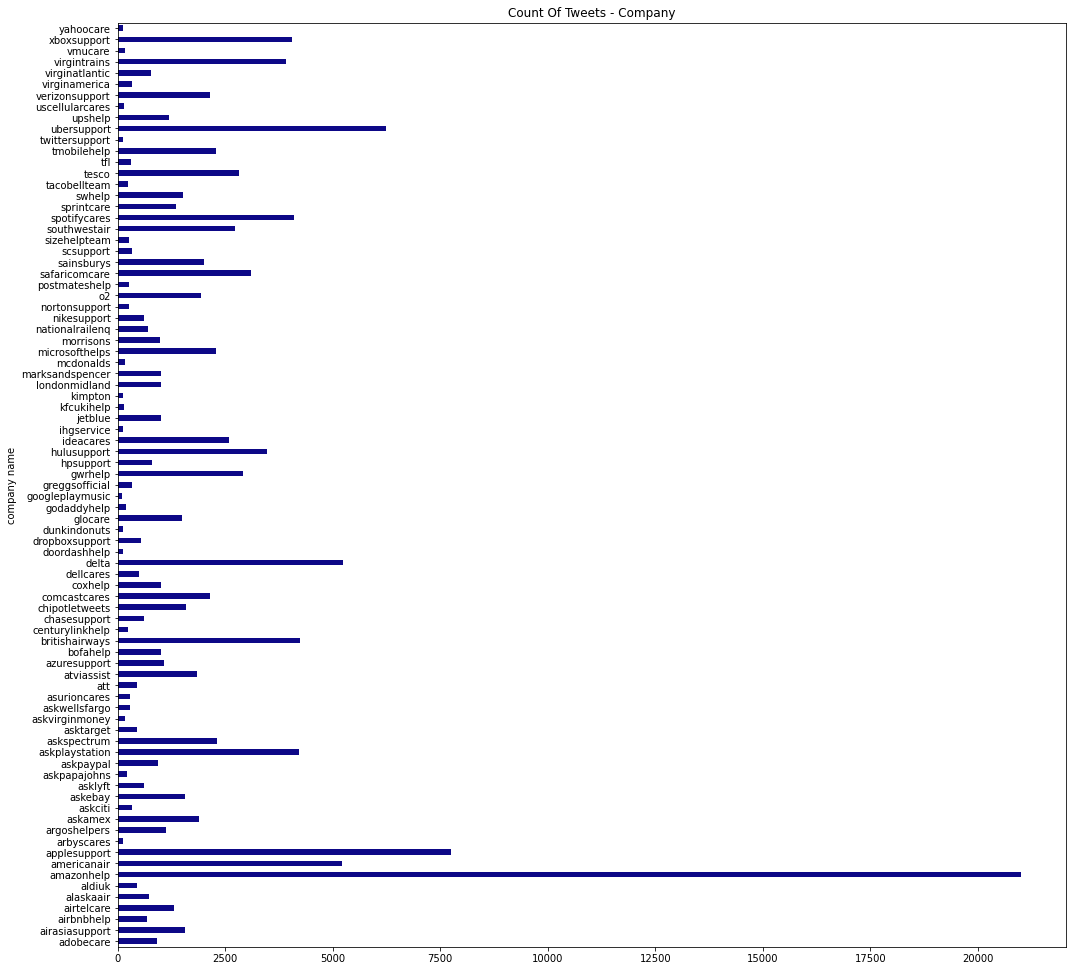

In [ ]:
df_.groupby(['company name'])['sentiment'].count().plot(kind='barh',stacked=False,figsize=(17,17),title = 'Count Of Tweets - Company',colormap='plasma')

In [ ]:
df_[df_['industry'] == 'AIRWAYS'].groupby('company name')['sentiment'].count().plot(kind='bar',stacked=False,figsize=(15,8),title = 'Count Of Tweets Within Companies in an Industry - Airways',colormap='plasma')

####  Split up of tweets sentiment wise - Industry ,Company Wise,Industry-Company wise.Will consider the companies having more than 3000 tweets count

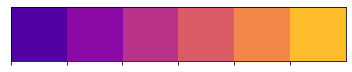

In [ ]:
### Setting plot color palette
palette = sns.color_palette("plasma")
sns.palplot(palette)
sns.set_palette("plasma")

In [ ]:
df_detailed = df_.groupby('company name').filter(lambda x : len(x)>3000)
df_detailed_industry = df_.groupby('industry').filter(lambda x : len(x)>3000)

KeyError: ignored

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='company name',data=df_detailed,hue='sentiment',palette=palette).set(title='Sentiment split across Companies')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='industry',data=df_detailed_industry,hue='sentiment',palette=palette).set(title='Sentiment split across all Industry')
plt.show()

#### Sentiment break up within a particular industry - Banking

In [ ]:
df_banks = df_[df_['industry'] == 'BANK']

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.countplot(y='company name',data=df_banks,hue='sentiment',palette=palette).set(title='Sentiment split across the Banking Industry')
plt.show()

#### Proportion of positive/negative tweets to overall tweets [Will tell about the company's overall performance tweetwise]

#### Across companies

In [ ]:
df_proportion = df_.groupby('company name').filter(lambda x : len(x)>3000)
df_proportion_total = df_proportion.groupby('company name').agg({'sentiment':'count'})
df_proportion_positive = df_proportion[df_proportion['sentiment']=='positive'].groupby('company name').agg({'sentiment':'count'})
df_proportion_negative = df_proportion[df_proportion['sentiment']=='negative'].groupby('company name').agg({'sentiment':'count'})
df_proportion_positive['label'] = 'positive'
df_proportion_negative['label'] = 'negative'
df_proportion_total.rename(columns = {'sentiment':'total'},inplace=True)
df_proportions = pd.concat([df_proportion_positive,df_proportion_negative],axis=0)
df_proportions = pd.merge(df_proportions,df_proportion_total,on='company name',how='inner')
df_proportions['percentage'] = (df_proportions['sentiment']/df_proportions['total'])*100
df_proportions.drop(['sentiment','total'],inplace=True,axis=1)

In [ ]:
df_proportions.reset_index(inplace=True)
pivot_df = df_proportions.pivot(index='company name', columns='label', values='percentage')
pivot_df

In [ ]:
pivot_df.loc[:,['negative','positive']].plot.bar(stacked=True, colormap='winter', figsize=(10,7),title = "Sentiment across companies")

#### Across an Industry - Telecom

In [ ]:
df_industry = df_[df_['industry'] == 'TELECOM']
df_proportion_ = df_industry.copy()
df_proportion_total_ = df_proportion_.groupby('company name').agg({'sentiment':'count'})
df_proportion_positive_ = df_proportion_[df_proportion_['sentiment']=='positive'].groupby('company name').agg({'sentiment':'count'})
df_proportion_negative_ = df_proportion_[df_proportion_['sentiment']=='negative'].groupby('company name').agg({'sentiment':'count'})
df_proportion_positive_['label'] = 'positive'
df_proportion_negative_['label'] = 'negative'
df_proportion_total_.rename(columns = {'sentiment':'total'},inplace=True)
df_proportions_ = pd.concat([df_proportion_positive_,df_proportion_negative_],axis=0)
df_proportions_ = pd.merge(df_proportions_,df_proportion_total_,on='company name',how='inner')
df_proportions_['percentage'] = (df_proportions_['sentiment']/df_proportions_['total'])*100
df_proportions_.drop(['sentiment','total'],inplace=True,axis=1)

In [ ]:
df_proportions_.reset_index(inplace=True)
pivot_df_ = df_proportions_.pivot(index='company name', columns='label', values='percentage')
pivot_df_

In [ ]:
pivot_df_.loc[:,['negative','positive']].plot.bar(stacked=True, colormap='winter', figsize=(10,7),title = "Sentiment across companies in Telecom")

### End of Inbound Tweets

### Let's look at Outbound Tweets

In [ ]:
df_new = df_input.copy()
print(df_new.shape)
df_new.dropna(inplace=True)
print(df_new.shape)

In [ ]:
df_new.inbound.value_counts()

In [ ]:
df_new['response_count'] = df_new['response_tweet_id'].apply(return_tweet_id)
df_greater_than_one = df_new[df_new['response_count']>1] ### These are tweets that have mulitple response tweet ids, requires more complex data transformations
df_equal_one = df_new[df_new['response_count']==1] ### These are tweets that have only one response tweet Id and we will use these

In [ ]:
now = time.time()
tweet_date_dict = dict(zip(df_new.tweet_id, df_new.created_at.values)) ## We will create a dictionary of a tweet_id and it's created_at date for lookup
print('minutes',(time.time() - now)/60)

In [ ]:
now = time.time()
df_equal_one['response_tweet_id'] = df_equal_one['response_tweet_id'].astype(float)
df_equal_one['response_create_dt'] = df_equal_one['response_tweet_id'].map(tweet_date_dict)
print('minutes',(time.time() - now)/60)

#### Calculate the difference between the date of the tweet and it's response tweet to calculate the difference in response times

In [ ]:
df_equal_one['response_create_dt'] = pd.to_datetime(df_equal_one['response_create_dt'])
df_equal_one['created_at'] = pd.to_datetime(df_equal_one['created_at'])
df_equal_one['response_time_days'] = (df_equal_one['response_create_dt'] - df_equal_one['created_at']).dt.days

In [ ]:
df_equal_one.inbound.value_counts() ### Outbound tweets are very low

In [ ]:
df_equal_one = df_equal_one[(df_equal_one['sentiment']!='neutral')]  ### Let's work only with positive and negative tweets

In [ ]:
print(df_equal_one.shape)
print(df_equal_one.inbound.value_counts())

In [ ]:
df_equal_one.dropna(inplace=True)
print(df_equal_one.shape)

In [ ]:
df_equal_one['company name'] = df_equal_one['author_id'] + df_equal_one['sent_to_user']  ### We need to create the company name using a combination of the inbound and outbound tweets

In [ ]:
df_equal_one['company name'].value_counts()

In [ ]:
df_equal_one['company name'] = df_equal_one['company name'].apply(eliminate_pattern,args=(company,))
df_equal_one.dropna(inplace=True)
df_equal_one['industry'] = df_equal_one['company name'].map(industry_dict)
df_equal_one.dropna(inplace=True)
df_equal_one = df_equal_one.groupby('company name').filter(lambda x : len(x)>1000)

In [ ]:
df_plot = df_equal_one.groupby(['company name','sentiment','tweet_id','inbound'])['response_time_days'].mean().reset_index()
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x = 'company name',y='response_time_days',data=df_plot,hue='inbound',ci = 0,palette='terrain').set(title='Average response time across Companies split by Inbound/Outbound')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x = 'company name',y='response_time_days',data=df_plot,hue='sentiment',ci = 0,palette='terrain').set(title='Average response time across Companies split by Sentiments')
plt.show()

### Product/Service Analysis

In [ ]:
df_new = df_input.copy()
print(df_new.shape)
df_new.dropna(inplace=True)
print(df_new.shape)
df_new['company name'] = df_new['sent_to_user'].apply(retain_org_names)
df_new.dropna(inplace=True)
df_new = df_new.groupby('company name').filter(lambda x : len(x)>2000)
df_new['industry'] = df_new['company name'].map(industry_dict)

In [ ]:
positive_tweets = df_new[df_new['sentiment'] == 'positive']
negative_tweets = df_new[df_new['sentiment'] == 'negative']

In [ ]:
print(positive_tweets.shape)
print(negative_tweets.shape)

### We will use Named Entity Recognition to identify any products services company names across the tweets,split into positive and negative for faster processing

In [ ]:
### Positive #namedEntityRecognition #ner/nlp = spacy
now = time.time() 
tweet_list_ps_1 = [''.join(x) for x in positive_tweets['feature_text'][0:10000]]
ner_ps_1 = nlp(' '.join(tweet_list_ps_1))
labels_ps_1 = [(x.text,x.label_) for x in ner_ps_1.ents]
tweet_list_ps_2 = [''.join(x) for x in positive_tweets['feature_text'][10000:20000]]
ner_ps_2 = nlp(' '.join(tweet_list_ps_2))
labels_ps_2 = [(x.text,x.label_) for x in ner_ps_2.ents]
tweet_list_ps_3 = [''.join(x) for x in positive_tweets['feature_text'][20000:30000]]
ner_ps_3 = nlp(' '.join(tweet_list_ps_3))
labels_ps_3 = [(x.text,x.label_) for x in ner_ps_3.ents]
tweet_list_ps_4 = [''.join(x) for x in positive_tweets['feature_text'][30000:]]
ner_ps_4 = nlp(' '.join(tweet_list_ps_4))
labels_ps_4 = [(x.text,x.label_) for x in ner_ps_4.ents]
labels_positive = labels_ps_1+labels_ps_2+labels_ps_3+labels_ps_4
ner_positive = pd.DataFrame(labels_positive,columns = ['key','entity'])
ner_positive['sentiment'] = 'positive'
print('minutes',(time.time() - now)/60)

In [ ]:
### Negative
now = time.time()
tweet_list_ng_1 = [''.join(x) for x in negative_tweets['feature_text'][0:10000]]
ner_ng_1 = nlp(' '.join(tweet_list_ng_1))
labels_ng_1 = [(x.text,x.label_) for x in ner_ng_1.ents]
tweet_list_ng_2 = [''.join(x) for x in negative_tweets['feature_text'][10000:20000]]
ner_ng_2 = nlp(' '.join(tweet_list_ng_2))
labels_ng_2 = [(x.text,x.label_) for x in ner_ng_2.ents]
tweet_list_ng_3 = [''.join(x) for x in negative_tweets['feature_text'][20000:30000]]
ner_ng_3 = nlp(' '.join(tweet_list_ng_3))
labels_ng_3 = [(x.text,x.label_) for x in ner_ng_3.ents]
tweet_list_ng_4 = [''.join(x) for x in negative_tweets['feature_text'][30000:]]
ner_ng_4 = nlp(' '.join(tweet_list_ng_4))
labels_ng_4 = [(x.text,x.label_) for x in ner_ng_4.ents]
labels_negative = labels_ng_1+labels_ng_2+labels_ng_3+labels_ng_4
ner_negative = pd.DataFrame(labels_negative,columns = ['key','entity'])
ner_negative['sentiment'] = 'negative'
print('minutes',(time.time() - now)/60)

In [ ]:
### The named entities will be returned based on what our data contains, so we can rename and remove noise,
### have excluded 'Amazon' as it is a clear outlier with a very high number of tweets.
clean_dict = {'amazon hope':'amazon','amazon time':'amazon'}
gibberish = ['abc','af','airplane mode','andy','ani','austin','battlefront','bell',
 'bin','bristol','chris','clai','wat','wtf','xmas','usa','usb','clai am','sierra','sky mile',
 'standby','storo bonus','temple mead','ton','tx','ty','uk','ur service','song','cont','delete','digital','dm',
  'mrp','msy','mile','miler','nbc','np','nut','oxford','password','phil','que','reg','reset password','milton keynes',
 'mm','max','mbps','mia','ffs','flight ba','fox','guy','hahaha','hr','hr delay','iet','inr','isp','item','jack','josh',
 'kbps','kcpe','kg','kinda','kiosk','klm','km','knw','ksh','la vega','lhr','lisa','amazon','ani amal','acc','acct','logistics',
'eta','eu','house','min','pixel','euston','preston','pri','psn','sec','time','swindon','un','ur','app','fed']
ner = pd.concat([ner_positive,ner_negative],axis=0)
ner['key'].replace(clean_dict,inplace=True)
named_entities= ner[((ner['entity']=='PRODUCT')|(ner['entity']=='ORG')|(ner['entity']=='PERSON'))]
named_entities = named_entities.groupby(['key','sentiment']).filter(lambda x: len(x)>5)
named_entities.drop(named_entities[named_entities['key'].isin(gibberish)].index,axis=0,inplace=True)
named_entities = named_entities.groupby(['key','sentiment']).count().reset_index()
pivot_named_entities= named_entities.pivot(index='key', columns='sentiment', values='entity')
pivot_named_entities.fillna(0,inplace=True)

In [ ]:
pivot_named_entities.loc[:,['negative','positive']].plot.bar(stacked=True,figsize=(15,8),title = 'Products/Organisations being discussed in the tweets with sentiment',colormap='winter')

### End of Insights based on Vader Sentiment Analysis